In [1]:
%autosave 300

Autosaving every 300 seconds


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections #for frequeny counting
import findspark
findspark.init("/.../spark2/")

import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit #create columns of *literal* value
from pyspark.sql.functions import col #Returns columns given on column name
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

In [3]:
import matplotlib.pyplot as plt
import warnings #for filtering warnings

#constants
%matplotlib inline
sns.set_style("dark")
#to ignore warnings in output
warnings.filterwarnings('ignore')
#global information settings
sigLev = 2 #three significant digits
percentMul = 100 #for percentage multiplication
figWidth = figHeight = 8

In [4]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector
from pyspark.sql import SparkSession


In [5]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
trainDF = spark.read.csv("titanic/train.csv", header="true")
testDF = spark.read.csv("titanic/test.csv", header="true")

In [7]:
## Add Survived column to test, and dataset name as a column
trainDF = trainDF.withColumn('Mark', lit('train'))
testDF = (testDF.withColumn('Survived',lit(0))
                .withColumn('Mark', lit('test')))
testDF = testDF[trainDF.columns]

## Append Test data to Train data
df = trainDF.unionAll(testDF)

In [8]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Mark']

In [9]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)



In [10]:
df.describe('Sex').show()

+-------+------+
|summary|   Sex|
+-------+------+
|  count|  1309|
|   mean|  null|
| stddev|  null|
|    min|female|
|    max|  male|
+-------+------+



In [11]:
df.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked| Mark|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25|     |       S|train|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|train|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925|     |       S|train|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|train|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05|     |       S|train|
+-----------+--------+------+-----------

In [12]:
# Let's define function
def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)

In [13]:
intCols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived']
floatCols = ['Age', 'Fare']

df = to_anytype(df, intCols, "integer")
df = to_anytype(df, floatCols, "float")

### Histogram Function

In [14]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

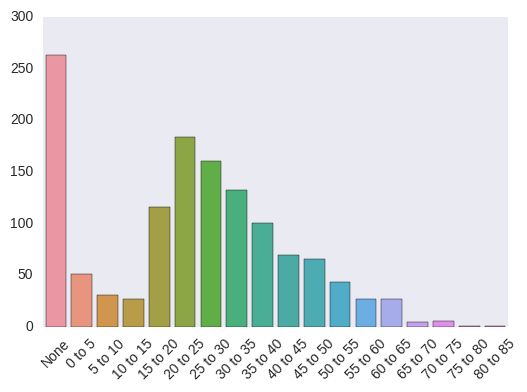

In [15]:
histplot(df, "Age", 5)

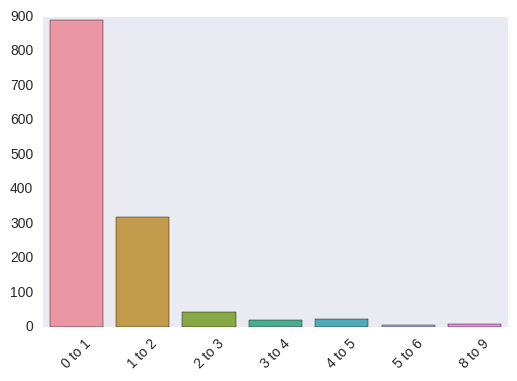

In [16]:
histplot(df, "SibSp", 1)

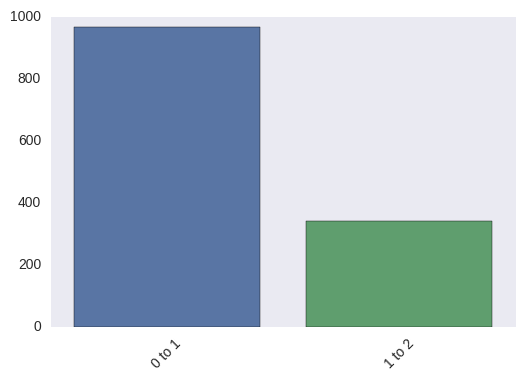

In [17]:
histplot(df, "Survived", 1)

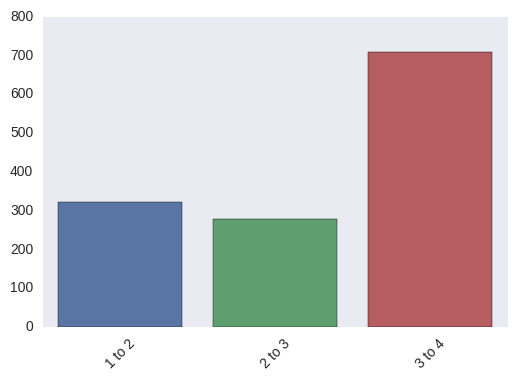

In [18]:
histplot(df, "Pclass", 1)

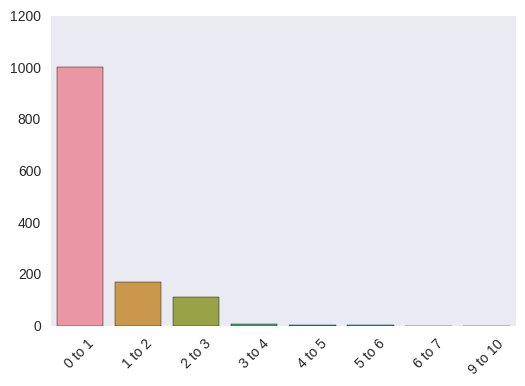

In [19]:
histplot(df, "Parch", 1)

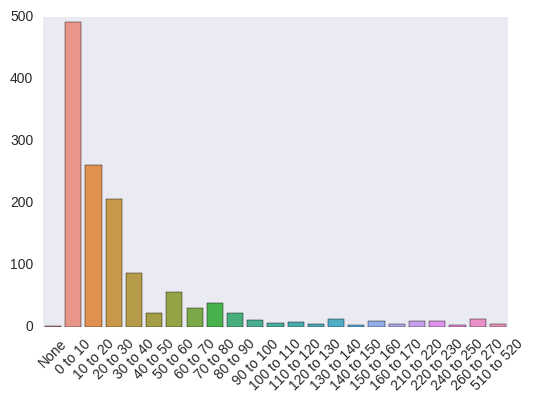

In [20]:
histplot(df, "Fare", 10)

### Histogram for categorical variable

In [21]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

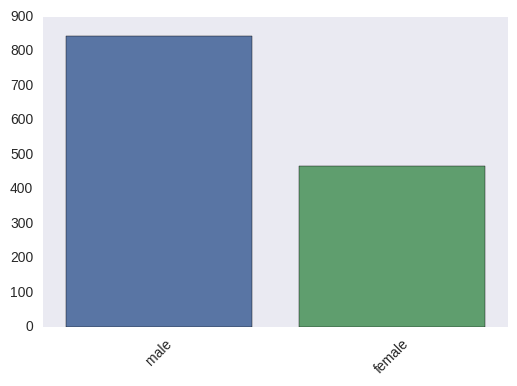

In [22]:
histplot_s(df, "Sex")

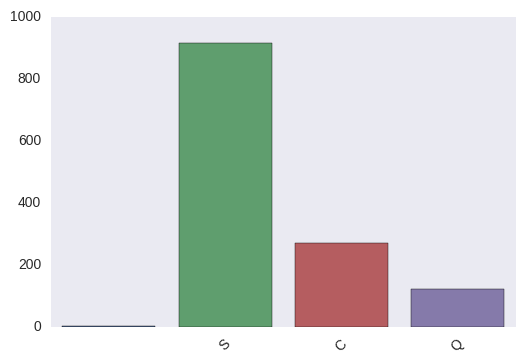

In [23]:
histplot_s(df, "Embarked")

### Missing valuw treatment

In [24]:
numVars = ['Survived','Age','SibSp','Parch','Fare']
stringVars = ['Cabin', 'Embarked', 'Pclass', 'Sex']

def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [25]:
missing = {var: countNull(df,var) for var in df.columns}
missing

{'Age': 263,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 1,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [26]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 1014,
 'Embarked': 2,
 'Fare': 0,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [27]:
missing = {var: countZero(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 17,
 'Mark': 0,
 'Name': 0,
 'Parch': 1002,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 891,
 'Survived': 967,
 'Ticket': 0}

In [28]:
age_mean = df.groupBy().mean('Age').first()
age_mean

Row(avg(Age)=29.881137667305726)

In [29]:
age_mean = df.groupBy().mean('Age').first()[0]
fare_mean = df.groupBy().mean('Fare').first()[0]
age_mean, fare_mean

(29.881137667305726, 33.29547938203228)

In [30]:
df = df.na.fill({'Age':age_mean,'Fare':fare_mean})

### Correlation plot

In [31]:
df_panda = df.toPandas()
df_panda.describe()

,PassengerId,Pclass,SibSp,Parch,Survived,Age,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,0.498854,0.385027,0.261268,29.881138,33.295479
std,378.020061,0.837836,1.041658,0.865560,0.439494,12.883193,51.738880
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.170000,0.000000
25%,328.000000,2.000000,0.000000,0.000000,0.000000,22.000000,7.895800
50%,655.000000,3.000000,0.000000,0.000000,0.000000,29.881138,14.454200
75%,982.000000,3.000000,1.000000,0.000000,1.000000,35.000000,31.275000
max,1309.000000,3.000000,8.000000,9.000000,1.000000,80.000000,512.329224


In [32]:
contFeaturelist = []
for colName, x in df_panda.iloc[1,:].iteritems():
    if(not str(x).isalpha()):
        contFeaturelist.append(colName)
        
print (contFeaturelist)

['Name', 'Ticket', 'Cabin', 'PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived', 'Age', 'Fare']


In [33]:
corr_matrix = df_panda[contFeaturelist].corr()
corr_matrix

,PassengerId,Pclass,SibSp,Parch,Survived,Age,Fare
PassengerId,1.000000,-0.038354,-0.055224,0.008942,-0.331493,0.025731,0.031416
Pclass,-0.038354,1.000000,0.060832,0.018322,-0.244686,-0.366371,-0.558477
SibSp,-0.055224,0.060832,1.000000,0.373587,-0.014375,-0.190747,0.160224
Parch,0.008942,0.018322,0.373587,1.000000,0.054908,-0.130872,0.221522
Survived,-0.331493,-0.244686,-0.014375,0.054908,1.000000,-0.060203,0.173630
Age,0.025731,-0.366371,-0.190747,-0.130872,-0.060203,1.000000,0.171521
Fare,0.031416,-0.558477,0.160224,0.221522,0.173630,0.171521,1.000000


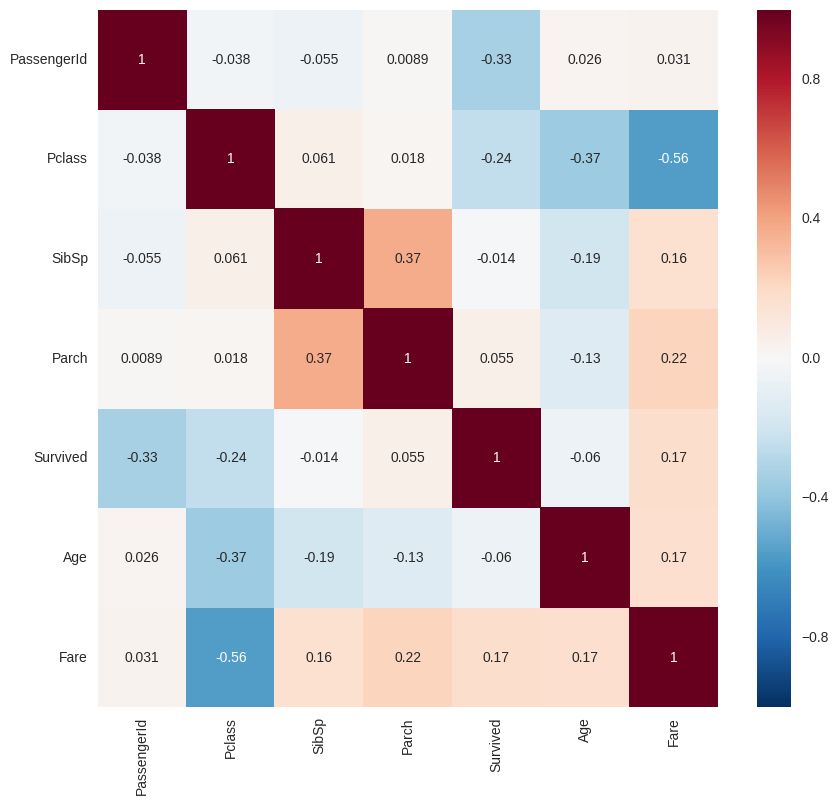

In [34]:
plt.subplots(figsize=(10,9))
corr_plt=sns.heatmap(corr_matrix, annot=True,
                    xticklabels=corr_matrix.columns.values,
                    yticklabels=corr_matrix.columns.values,)

corr_plt = sns.heatmap(corr_matrix,mask = corr_matrix < 1, cbar=False)

for item in corr_plt.get_xticklabels():
    item.set_rotation(90)
for item in corr_plt.get_yticklabels():
    item.set_rotation(360)

### Boxplot (Age, Survived , Fare)

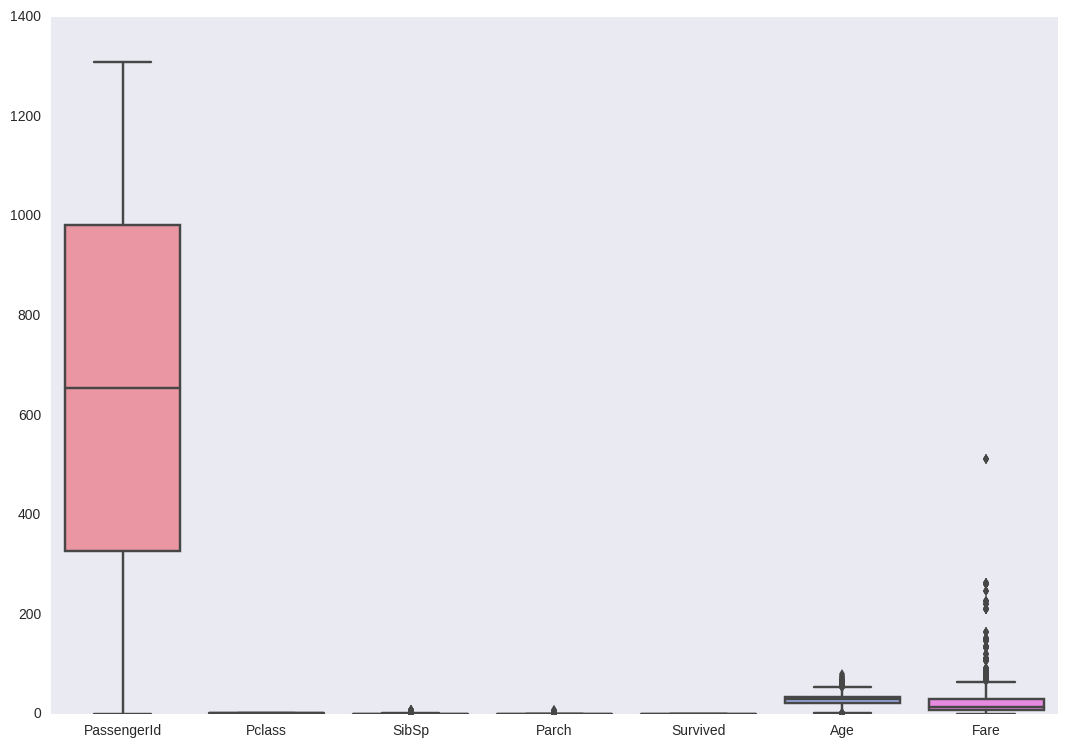

In [35]:
plt.figure(figsize=(13,9))
sns.boxplot(df_panda[contFeaturelist])

### Feature Engineering

In [36]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
## create user defined function to extract title
getTitle = udf(lambda name: name.split('.')[0].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+---------------+
|                Name|          Title|
+--------------------+---------------+
|Braund, Mr. Owen ...|     Braund, Mr|
|Cumings, Mrs. Joh...|   Cumings, Mrs|
|Heikkinen, Miss. ...|Heikkinen, Miss|
|Futrelle, Mrs. Ja...|  Futrelle, Mrs|
|Allen, Mr. Willia...|      Allen, Mr|
+--------------------+---------------+
only showing top 5 rows



In [37]:
getTitle = udf(lambda name: name.split('.')[0].split(',')[1].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+-----+
|                Name|Title|
+--------------------+-----+
|Braund, Mr. Owen ...|   Mr|
|Cumings, Mrs. Joh...|  Mrs|
|Heikkinen, Miss. ...| Miss|
|Futrelle, Mrs. Ja...|  Mrs|
|Allen, Mr. Willia...|   Mr|
+--------------------+-----+
only showing top 5 rows



In [38]:
catVars = ['Pclass','Sex','Embarked','Title']
 
## index Sex variable
si = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
df_indexed = si.fit(df).transform(df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')

In [39]:
df_indexed.show(5)

+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|                Name|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|Sex|
+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|Braund, Mr. Owen ...|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|   Mr|0.0|
|Cumings, Mrs. Joh...|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|  Mrs|1.0|
|Heikkinen, Miss. ...|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925| Miss|1.0|
|Futrelle, Mrs. Ja...|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|  Mrs|1.0|
|Allen, Mr. Willia...|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|   Mr|0.0|
+-------

In [40]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

In [41]:
pipeline = Pipeline(stages = indexers)
df_indexed = pipeline.fit(df).transform(df)
 
df_indexed.select('Embarked','Embarked_indexed').show(3)

+--------+----------------+
|Embarked|Embarked_indexed|
+--------+----------------+
|       S|             0.0|
|       C|             1.0|
|       S|             0.0|
+--------+----------------+
only showing top 3 rows



In [42]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

### Data Format translation

In [43]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['Pclass_indexed', 'Sex_indexed', 'Embarked_indexed', 'Title_indexed']

In [44]:
featuresCol = numVars + catVarsIndexed
featuresCol

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [45]:
featuresCol.remove('Survived')
featuresCol

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [46]:
labelCol = ['Mark','Survived']
labelCol

['Mark', 'Survived']

In [47]:
row = Row('mark','label','features') 
row

<Row(mark, label, features)>

In [48]:
df_indexed = df_indexed[labelCol + featuresCol]
df_indexed

DataFrame[Mark: string, Survived: int, Age: float, SibSp: int, Parch: int, Fare: float, Pclass_indexed: double, Sex_indexed: double, Embarked_indexed: double, Title_indexed: double]

In [49]:
# 0-mark, 1-label, 2-features
# map features to DenseVector
lf = df_indexed.rdd.map(lambda r: (row(r[0], r[1],DenseVector(r[2:])))).toDF()
lf.show()

+-----+-----+--------------------+
| mark|label|            features|
+-----+-----+--------------------+
|train|    0|[22.0,1.0,0.0,7.2...|
|train|    1|[38.0,1.0,0.0,71....|
|train|    1|[26.0,0.0,0.0,7.9...|
|train|    1|[35.0,1.0,0.0,53....|
|train|    0|[35.0,0.0,0.0,8.0...|
|train|    0|[29.8811378479003...|
|train|    0|[54.0,0.0,0.0,51....|
|train|    0|[2.0,3.0,1.0,21.0...|
|train|    1|[27.0,0.0,2.0,11....|
|train|    1|[14.0,1.0,0.0,30....|
|train|    1|[4.0,1.0,1.0,16.7...|
|train|    1|[58.0,0.0,0.0,26....|
|train|    0|[20.0,0.0,0.0,8.0...|
|train|    0|[39.0,1.0,5.0,31....|
|train|    0|[14.0,0.0,0.0,7.8...|
|train|    1|[55.0,0.0,0.0,16....|
|train|    0|[2.0,4.0,1.0,29.1...|
|train|    1|[29.8811378479003...|
|train|    0|[31.0,1.0,0.0,18....|
|train|    1|[29.8811378479003...|
+-----+-----+--------------------+
only showing top 20 rows



In [50]:
# index label
# convert numeric label to categorical, which is required by
# decisionTree and randomForest
model = StringIndexer(inputCol = 'label', outputCol='index').fit(lf)
lf = model.transform(lf)
 
lf.show(3)

+-----+-----+--------------------+-----+
| mark|label|            features|index|
+-----+-----+--------------------+-----+
|train|    0|[22.0,1.0,0.0,7.2...|  0.0|
|train|    1|[38.0,1.0,0.0,71....|  1.0|
|train|    1|[26.0,0.0,0.0,7.9...|  1.0|
+-----+-----+--------------------+-----+
only showing top 3 rows



In [51]:
lf.printSchema()

root
 |-- mark: string (nullable = true)
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- index: double (nullable = true)



In [52]:
train = lf.where(lf.mark =='train')
test = lf.where(lf.mark =='test')

### Random Forest

In [53]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [54]:
rf = RandomForestRegressor(numTrees=200, maxDepth=6, maxMemoryInMB=512,minInstancesPerNode=3,
                           seed=14, labelCol = 'index')

In [55]:
model_rf = rf.fit(train)

In [56]:
prediction_rf = model_rf.transform(test)
prediction_rf.head()

Row(mark='test', label=0, features=DenseVector([34.5, 0.0, 0.0, 7.8292, 0.0, 0.0, 2.0, 0.0]), index=0.0, prediction=0.07932958364694946)

In [57]:
prediction_rf.createOrReplaceTempView('pred_rf')
testDF.createOrReplaceTempView("test")

In [58]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction_rf)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.521694


In [59]:
model_rf.featureImportances.values,model_rf.featureImportances.indices

(array([ 0.06267863,  0.04939437,  0.02020163,  0.14690354,  0.12688386,
         0.27527346,  0.02647816,  0.29218635]),
 array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32))

In [60]:
pred_rf_col = spark.sql(
    "SELECT prediction from pred_rf")
id_col = spark.sql(
    "SELECT PassengerId from test")

In [61]:
id = id_col.toPandas().values.T.tolist()
prediction_rf = pred_rf_col.toPandas().values.T.tolist()

In [62]:
result = pd.DataFrame({"PassengerId" : id[0], "Survived" : prediction_rf[0]})

In [63]:
result.to_csv("submission/submission_rf_6.csv", index=False)

#### GBT

In [64]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor

In [65]:
gbt = GBTRegressor(labelCol = 'label', maxDepth=4, maxBins=25,stepSize=0.001,minInstancesPerNode=2,
                   maxIter=8,  maxMemoryInMB=512)

In [66]:
model_gbt = gbt.fit(train)

In [67]:
model_gbt.transform(test).head().prediction

0.03857506535120434

In [68]:
prediction_gbt = model_gbt.transform(test)
prediction_gbt

DataFrame[mark: string, label: bigint, features: vector, index: double, prediction: double]

In [69]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction_gbt)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.527625


In [70]:
prediction_gbt.createOrReplaceTempView('pred_gbt')
testDF.createOrReplaceTempView("test")

In [71]:
prediction_col = spark.sql(
    "SELECT prediction from pred_gbt")
id_col = spark.sql(
    "SELECT PassengerId from test")

In [72]:
id = id_col.toPandas().values.T.tolist()
prediction_gbt = prediction_col.toPandas().values.T.tolist()

In [73]:
result = pd.DataFrame({"PassengerId" : id[0], "Survived" : prediction_gbt[0]})

In [74]:
result.to_csv("submission/submission_gbt_3.csv", index=False)

### Decision tree

In [75]:
from pyspark.ml.regression import DecisionTreeRegressor


In [76]:
dt = DecisionTreeRegressor(maxDepth=3, maxMemoryInMB=512,minInstancesPerNode=2, seed=673, labelCol = 'label')

In [77]:
model_dt = dt.fit(train)

In [78]:
prediction_dt = model_dt.transform(test)
prediction_dt.head()

Row(mark='test', label=0, features=DenseVector([34.5, 0.0, 0.0, 7.8292, 0.0, 0.0, 2.0, 0.0]), index=0.0, prediction=0.061224489795918366)

In [79]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction_dt)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.522186


In [80]:
prediction_dt.createOrReplaceTempView('pred_dt')
testDF.createOrReplaceTempView("test")

In [81]:
model_rf.featureImportances.values,model_rf.featureImportances.indices

(array([ 0.06267863,  0.04939437,  0.02020163,  0.14690354,  0.12688386,
         0.27527346,  0.02647816,  0.29218635]),
 array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32))

In [82]:
prediction_col = spark.sql(
    "SELECT prediction from pred_dt")
id_col = spark.sql(
    "SELECT PassengerId from test")

In [83]:
id = id_col.toPandas().values.T.tolist()
prediction_dt = prediction_col.toPandas().values.T.tolist()

In [84]:
result = pd.DataFrame({"PassengerId" : id[0], "Survived" : prediction_dt[0]})

In [85]:
result.to_csv("submission/submission_dt_3.csv", index=False)